In [1]:
import os
import cftime
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import xarray as xr
import plotly.graph_objects as go
import plotly.express as px
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import cm

#from scipy import stats, interpolate
#%matplotlib osx 
%matplotlib inline

In [2]:
#matplotlib parameters
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({'font.size':14})

In [3]:
os.listdir("./") 

['Final-Simulate_Displacement.ipynb',
 '.DS_Store',
 'code.ipynb',
 'markov_test.ipynb',
 'Vietnam_Migration_D1.ipynb',
 'Vietnam_FloodDisplacement_D2.ipynb',
 '.ipynb_checkpoints',
 'Prep_Weather.ipynb',
 'Data',
 'Vietnam_FloodDisplacement_D3.ipynb',
 'Simulate_Displacement.ipynb',
 'Simulate_Displacement.mp4']

### Out Migration Data for Viet Nam
Source: https://www.gso.gov.vn/en/px-web/?pxid=E0221-23&theme=Population%20and%20Employment

In [4]:
filename = "./Data/Migration/VN_OutMigration-M1.csv"
df_raw = pd.read_csv(filename, header = 3)

df = df_raw.rename(columns = {'Prel. 2021':'2021'})
df = df.set_index(["Subregion", "Province", "Flood_2011", "Flood_2020"]).stack().reset_index().rename(columns={"level_4":"year", 0:"migration_out"})

df[df == ".."] = np.nan
df["year"] = df["year"].astype(int)
df['migration_out'] = df["migration_out"].astype(float)

df.loc[df.Flood_2011 == True] ###

Subregion   Province Flood_2011 Flood_2020  year  migration_out
816  Mekong River Delta    Long An       True      False  2005           6.50
817  Mekong River Delta    Long An       True      False  2007          10.20
818  Mekong River Delta    Long An       True      False  2008           8.70
819  Mekong River Delta    Long An       True      False  2009           9.90
820  Mekong River Delta    Long An       True      False  2010           9.00
..                  ...        ...        ...        ...   ...            ...
971  Mekong River Delta  Hau Giang       True      False  2017           8.90
972  Mekong River Delta  Hau Giang       True      False  2018           6.40
973  Mekong River Delta  Hau Giang       True      False  2019          14.60
974  Mekong River Delta  Hau Giang       True      False  2020          25.08
975  Mekong River Delta  Hau Giang       True      False  2021          18.81

[112 rows x 6 columns]

### Precipitation Data
Two parameters will be used: Runoff (Table 3, #35); Total Precipitation (Table 3, #36)
- Parameter details: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings
- Data source: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form

Rectangular Viet Nam (lat/lon):
- NE: 23.360331, 102.008722
- NW: 23.702802, 108.161065
- SW: 8.339692, 109.809014
- SE: 8.709100, 102.492120

In [5]:
data = xr.open_dataset("./Data/ERA5_ClimateData.nc")
display(data) #interactive display

<xarray.Dataset>
Dimensions:    (latitude: 65, longitude: 33, time: 8760)
Coordinates:
  * longitude  (longitude) float32 102.0 102.2 102.5 102.8 ... 109.5 109.8 110.0
  * latitude   (latitude) float32 24.0 23.75 23.5 23.25 ... 8.75 8.5 8.25 8.0
  * time       (time) datetime64[ns] 2011-01-01 ... 2011-12-31T23:00:00
Data variables:
    ro         (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-12-12 01:39:03 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

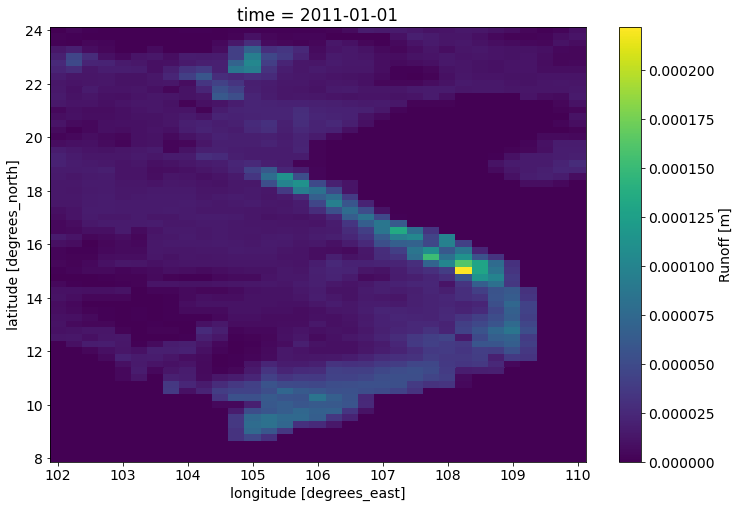

In [6]:
ro = data['ro']
ro[0].plot()

In [7]:
ro

<xarray.DataArray 'ro' (time: 8760, latitude: 65, longitude: 33)>
[18790200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 102.0 102.2 102.5 102.8 ... 109.5 109.8 110.0
  * latitude   (latitude) float32 24.0 23.75 23.5 23.25 ... 8.75 8.5 8.25 8.0
  * time       (time) datetime64[ns] 2011-01-01 ... 2011-12-31T23:00:00
Attributes:
    units:      m
    long_name:  Runoff

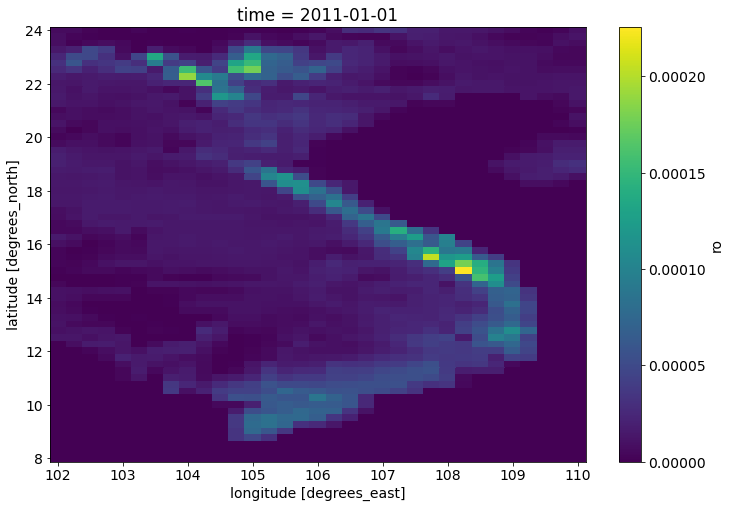

In [8]:
# Read and resampling data
ro = ro.resample(time='D').max() # convert hourly runoff data --> max runoff daaily value
ro[0].plot()

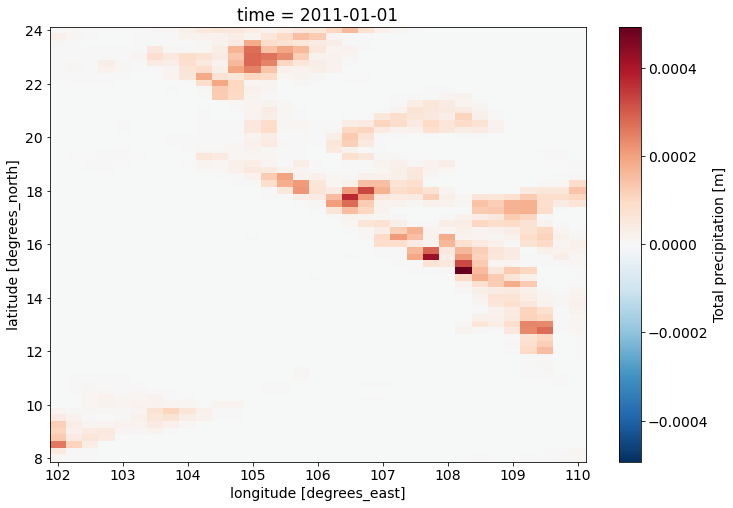

In [9]:
tp = data['tp']
tp[0].plot()

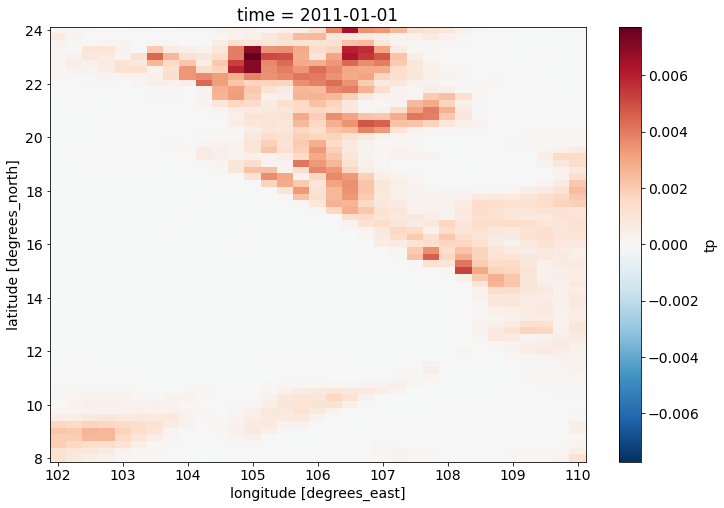

In [10]:
# Read and resampling data
tp = tp.resample(time='D').sum() # convert hourly precip data --> total daily precip value
tp[0].plot()

### Markov Chains
- Videos: 
    - https://www.youtube.com/watch?v=WT6jI8UgROI
    - https://setosa.io/ev/markov-chains/
- Code Source: https://github.com/tudev/Workshops-2020-2021/blob/master/Python%20YouTube%20Tutorials/An_Intro_to_Markov_chains_with_Python!.ipynb

In [11]:
# Potential Modes: 'Stuck', 'Rescued', 'Travel_away', 'Travel_home', 'Sick', 'Rest_safe'
# Dummy probabilities
mc_prob = {'Stuck': [.55,.5,.25,.75,0,0],
      'Rescued': [.15,0,0,0,.25,0],
      'Travel_away': [.15,0,.25,0,0,0],
      'Travel_home': [0,0,0,0,0,.25],
      'Sick': [.15,0,.25,.25,.75,0],
      'Rest_safe': [0,.5,.25,0,0,.75]}

mc = pd.DataFrame(data= mc_prob, index = ['Stuck', 'Rescued', 'Travel_away', 'Travel_home', 'Sick', 'Rest_safe'])

In [12]:
mc

Stuck  Rescued  Travel_away  Travel_home  Sick  Rest_safe
Stuck         0.55     0.15         0.15         0.00  0.15       0.00
Rescued       0.50     0.00         0.00         0.00  0.00       0.50
Travel_away   0.25     0.00         0.25         0.00  0.25       0.25
Travel_home   0.75     0.00         0.00         0.00  0.25       0.00
Sick          0.00     0.25         0.00         0.00  0.75       0.00
Rest_safe     0.00     0.00         0.00         0.25  0.00       0.75

In [13]:
# Migration simulation
migr_sim = []
migr_sim.append(mc.iloc[0].index[0]) #initial state at beginning of simulation = stuck (i.e., staying in the home)
mode = np.random.choice(mc.iloc[0].index, p = mc.iloc[0])
migr_sim.append(mode)

while len(migr_sim) < 25:
    mode = np.random.choice(mc.iloc[mc.index.get_loc(mode)].index, p = mc.iloc[mc.index.get_loc(mode)]) # randomly chooses next state based on current state
    migr_sim.append(mode)

In [14]:
migr_sim

['Stuck',
 'Stuck',
 'Travel_away',
 'Travel_away',
 'Stuck',
 'Sick',
 'Sick',
 'Sick',
 'Sick',
 'Sick',
 'Rescued',
 'Rest_safe',
 'Rest_safe',
 'Rest_safe',
 'Rest_safe',
 'Travel_home',
 'Stuck',
 'Sick',
 'Sick',
 'Sick',
 'Sick',
 'Sick',
 'Rescued',
 'Rest_safe',
 'Rest_safe']

### n Step Transition Matrix
The probability of reaching a certain future state given your current state at n steps 

In [15]:
mc.to_numpy() # converts dataframe to np array

array([[0.55, 0.15, 0.15, 0.  , 0.15, 0.  ],
       [0.5 , 0.  , 0.  , 0.  , 0.  , 0.5 ],
       [0.25, 0.  , 0.25, 0.  , 0.25, 0.25],
       [0.75, 0.  , 0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.25, 0.  , 0.  , 0.75, 0.  ],
       [0.  , 0.  , 0.  , 0.25, 0.  , 0.75]])

In [16]:
np.dot(mc.to_numpy(),mc.to_numpy()) #new probabilities in 2 steps; dot product of the initial states --> tells you probability in two steps

array([[0.415 , 0.12  , 0.12  , 0.    , 0.2325, 0.1125],
       [0.275 , 0.075 , 0.075 , 0.125 , 0.075 , 0.375 ],
       [0.2   , 0.1   , 0.1   , 0.0625, 0.2875, 0.25  ],
       [0.4125, 0.175 , 0.1125, 0.    , 0.3   , 0.    ],
       [0.125 , 0.1875, 0.    , 0.    , 0.5625, 0.125 ],
       [0.1875, 0.    , 0.    , 0.1875, 0.0625, 0.5625]])

In [17]:
# Creating a function for any step we want instead of manually
def matrix_power(matrix, power): # power = matrix**power
    if power == 0:
        return np.identity(len(matrix))
    elif power == 1:
        return matrix
    else:
        return np.dot(matrix, matrix_power(matrix,power-1))

In [18]:
matrix_power(mc.to_numpy(), 2) #matches what we did manually

array([[0.415 , 0.12  , 0.12  , 0.    , 0.2325, 0.1125],
       [0.275 , 0.075 , 0.075 , 0.125 , 0.075 , 0.375 ],
       [0.2   , 0.1   , 0.1   , 0.0625, 0.2875, 0.25  ],
       [0.4125, 0.175 , 0.1125, 0.    , 0.3   , 0.    ],
       [0.125 , 0.1875, 0.    , 0.    , 0.5625, 0.125 ],
       [0.1875, 0.    , 0.    , 0.1875, 0.0625, 0.5625]])

In [19]:
matrix_power(mc.to_numpy(), 2).sum(axis=1) #shows that probabilities all correctly add up to 1

array([1., 1., 1., 1., 1., 1.])

In [20]:
# Determine what value probabilities will converge to (stationary distribution/steady state vector)
# Long term probability of ending in a specific state
for i in range(1,10,1):
    print(f'n Step Transition Matrix at the nth power {i}\n', matrix_power(mc.to_numpy(), i), '\n')

n Step Transition Matrix at the nth power 1
 [[0.55 0.15 0.15 0.   0.15 0.  ]
 [0.5  0.   0.   0.   0.   0.5 ]
 [0.25 0.   0.25 0.   0.25 0.25]
 [0.75 0.   0.   0.   0.25 0.  ]
 [0.   0.25 0.   0.   0.75 0.  ]
 [0.   0.   0.   0.25 0.   0.75]] 

n Step Transition Matrix at the nth power 2
 [[0.415  0.12   0.12   0.     0.2325 0.1125]
 [0.275  0.075  0.075  0.125  0.075  0.375 ]
 [0.2    0.1    0.1    0.0625 0.2875 0.25  ]
 [0.4125 0.175  0.1125 0.     0.3    0.    ]
 [0.125  0.1875 0.     0.     0.5625 0.125 ]
 [0.1875 0.     0.     0.1875 0.0625 0.5625]] 

n Step Transition Matrix at the nth power 3
 [[0.31825  0.120375 0.09225  0.028125 0.266625 0.174375]
 [0.30125  0.06     0.06     0.09375  0.1475   0.3375  ]
 [0.231875 0.101875 0.055    0.0625   0.28625  0.2625  ]
 [0.3425   0.136875 0.09     0.       0.315    0.115625]
 [0.1625   0.159375 0.01875  0.03125  0.440625 0.1875  ]
 [0.24375  0.04375  0.028125 0.140625 0.121875 0.421875]] 

n Step Transition Matrix at the nth power 4
 [

### Mapping Person's Mode to Speed 
Currently direction = random.uniform 

In [23]:
# Assigning dummy speeds, km/day
s_fast = 60 
s_mod = 30
s_slow = 15

# Creating dictionary
mode_to_speed = {
    'Stuck': 0, 
    'Rescued': s_fast, 
    'Travel_away': s_mod, 
    'Travel_home':s_slow, 
    'Sick': 0 , 
    'Rest_safe': 0
}

print(mode_to_speed['Travel_away']) 

30


### Model
- Videos: https://www.youtube.com/watch?v=iH2kATv49rc


In [24]:
# Distances are in km
def lonlat_to_xy(lon, lat, lon0, lat0): 
    x = (lon-lon0)*40000*math.cos((lat+lat0)*math.pi/360)/360 
    y = (lat-lat0)*40000/360  
    return x, y 

# Convert every timstep so I can check which province code each person is
# longlat to provincecode
def xy_to_lonlat(x, y, lon0, lat0): 
    lat = lat0 + y / (40000/360) 
    lon = lon0 + x / (40000*math.cos((lat+lat0)*math.pi/360)/360) 
    return lon, lat 

def lookup_weather(lon, lat, t, wdata): # wdata = weat data = precip, runoff 
    weather = wdata.where(
        (wdata.longitude==np.around(lon)) & 
        (wdata.latitude==np.around(lat)) & 
        (wdata.time == t_start + pd.Timedelta(t, "d")), 
        drop=True
    ).values[0][0][0]
    return weather
        
# in lookup_precip, convert indiv lon/lat to grid cell with precip 
# --> we accounted for this in the "around" action in net cdf --> finds nearest precip 

In [25]:
print(ro.max())
print(tp.max())

<xarray.DataArray 'ro' ()>
array(0.02854824, dtype=float32)
<xarray.DataArray 'tp' ()>
array(0.3271238, dtype=float32)


In [26]:
# Rectangular Viet Nam
min_lon = 102.213804
min_lat = 8.625221
max_lon = 109.368977
max_lat = 23.295628

min_x, min_y = 0, 0 
max_x, max_y = lonlat_to_xy(max_lon, max_lat, min_lon, min_lat) 

# first date time 
t_start = pd.to_datetime('2011-01-01')

# dummy thresholds
ro_thres = 0.001
tp_thres = 0.1
coef_ro = 6600.7 # km/day/m of runoff above threshold, slope of speed increase
# next: define coefficient for precip 

In [27]:
# Initial conditions
nPeople = 10 
nt = 365

x = np.empty((nPeople, nt))
x[:] = np.nan 
y = np.empty((nPeople, nt))
y[:] = np.nan 
lon = np.empty((nPeople, nt)) 
lon[:] = np.nan 
lat = np.empty((nPeople, nt)) 
lat[:] = np.nan 
mode = np.empty((nPeople, nt),dtype=object) 
mode[:] = ""
speed = np.empty((nPeople, nt)) 
speed[:] = np.nan
angle = np.empty((nPeople, nt)) 
angle[:] = np.nan
precip = np.empty((nPeople, nt))
precip[:] = np.nan
runoff = np.empty((nPeople, nt))
runoff[:] = np.nan

# Center of the 7 provinces with 2011 storm (lon, lat)
start_position_2011 = [(106.228200,10.725066), (106.012269, 10.093019), (105.652335, 10.577268), (105.204224, 10.495050), (105.122017, 9.961549), (105.758850, 10.037041), (105.649856, 9.785156) ]

# Center of 7 non-storm provinces
#start_position_no_2011 = [(106.374654, 20.918735),(105.284857, 22.077916),(104.156936, 21.193406),(106.962230, 16.713649),(108.094396,11.126926),(108.294724, 12.771274),(106.145824, 11.393226)]

# Combined list of start positions (lon/lat)
#start_position = [(106.228200,10.725066), (106.012269, 10.093019), (105.652335, 10.577268), (105.204224, 10.495050), (105.122017, 9.961549), (105.758850, 10.037041), (105.649856, 9.785156), (106.374654, 20.918735),(105.284857, 22.077916),(104.156936, 21.193406),(106.962230, 16.713649),(108.094396,11.126926),(108.294724, 12.771274),(106.145824, 11.393226)]

for i in range(0,nPeople): 
    #initial positions for each person = center of Long An
    lon[i,0]  = start_position_2011[0][0]
    lat[i,0]  = start_position_2011[0][1]
    x[i,0], y[i,0] = lonlat_to_xy(lon[i,0], lat[i,0], min_lon, min_lat)
    mode[i,0] = 'Stuck'

In [28]:
for i in range(0,nPeople):
    for t in range(0, nt-1):
        precip[i,t] = lookup_weather(lon[i,t], lat[i,t], t, tp) # create lookup function
        runoff[i,t] = lookup_weather(lon[i,t], lat[i,t], t, ro)

        speed[i,t] = mode_to_speed[mode[i,t]]            
        angle[i,t] = np.random.uniform(0,2*np.pi)

        speed[i,t] = min(max(coef_ro*(runoff[i,t]-ro_thres),0), speed[i,t]) # define upper and lower bounds of speed depending on runoff


        # convert from polar to cartesian coordinates
        vx = speed[i,t] * np.cos(angle[i,t])
        vy = speed[i,t] * np.sin(angle[i,t])

        # position
        x[i,t+1]  = x[i, t] + vx 
        y[i,t+1]  = y[i, t] + vy

        mode[i,t+1] = np.random.choice(
            mc.iloc[mc.index.get_loc(mode[i,t])].index, 
            p = mc.iloc[mc.index.get_loc(mode[i,t])]
            )

        lon[i,t+1], lat[i,t+1] = xy_to_lonlat(x[i,t+1], y[i,t+1], min_lon, min_lat) 

        if t%360 == 0:
            print(i,t)          

0 0
0 360
1 0
1 360
2 0
2 360
3 0
3 360
4 0
4 360
5 0
5 360
6 0
6 360
7 0
7 360
8 0
8 360
9 0
9 360


In [55]:
%matplotlib osx

# Pop up animation
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Simulate_Displacement', artist='ThaoTran',comment='migration')
writer = FFMpegWriter(fps=15, metadata=metadata)
fig = plt.figure()

xmin = np.min(lon[:10,:]) - 0.1 
xmax = np.max(lon[:10,:]) + 0.1 
ymax = np.max(lat[:10,:]) + 0.1
ymin = np.min(lat[:10,:]) - 0.1

with writer.saving(fig,"Simulate_Displacement.mp4", dpi = 200): # need to save video (1/2)
    for t in range(nt):
    #for t in [0,30,60,90,120,150,180,210,240,270,300,330,364]: 
        plt.clf()
        for i in range(nPeople): 
            plt.plot(lon[i,:t], lat[i,:t])

        plt.xlim([xmin, xmax]) 
        plt.ylim([ymin, ymax]) 
        plt.title("Flood-induced Daily Displacement of 10 Individuals in 2011")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
        plt.draw()
        plt.pause(0.01) # choose the time argument between 0.01 and 0.5
        writer.grab_frame() # need to save video (2/2)

In [40]:
import plotly.graph_objects as go

# Individual A
fig = go.Figure(go.Scattermapbox(
    mode = "lines",
    lon = lon[0,:],
    lat = lat[0,:],
    marker = {'size': 10}))


# Remaining individuals
for i in range(1, nPeople): 
    fig.add_trace(go.Scattermapbox(
        mode = "lines",
        lon = lon[i,:],
        lat = lat[i,:],
        marker = {'size': 10}))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': 10, 'lat': 10},
        'style': "stamen-terrain",
        'center': {'lon': -20, 'lat': -20},
        'zoom': 1})

fig.show()